### FER-Facial Expression Recognition

This project is aimed for building a Deep Convolution Neural network for classifying the emotions of a person using the facial image. Below are the expressions included in the dataset which is represented by a respective number encoding.
<p>

<li>0=Angry</li>
<li>1=Disgust</li>
<li>2=Fear</li>
<li>3=Happy</li>
<li>4=Sad</li>
<li>5=Surprise</li>
<li>6=Neutral</li>
<br>
This dataset has been taken from the <a href="https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data">Facial Expression Recognition Challenge Kaggle competiion</a>
</p>

In [1]:
import tarfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from kaggle.api.kaggle_api_extended import KaggleApi

### Download and extract the data
Keep you api key in the ~/.kaggle directory.

In [2]:
api = KaggleApi()
api.authenticate()
competition_name = "challenges-in-representation-learning-facial-expression-recognition-challenge" 
api.competition_download_files(competition_name, "./data")

root_dir = "./"
tar = tarfile.open(root_dir+"data/fer2013.tar.gz", "r:gz")
tar.extractall(root_dir+"data/")
tar.close()

**Read the data**

Read the data from the csv and seperate the training, public and private test. Then extract the pixels values into a numpy array. We will also define a emotion enocoding map

In [3]:
%%time
root_dir="./"
data = pd.read_csv(root_dir+"data/fer2013/fer2013.csv")
data=data.sample(frac=1).reset_index(drop=True)
train_data = data[data['Usage']=="Training"]
pub_test_data = data[data['Usage']=="PublicTest"]
pri_test_data = data[data['Usage']=="PrivateTest"]
emotion_mapping = {0:"Angry",1:"Disgust",2:"Fear",3:"Happy",4:"Sad",5:"Surprise",6:"Neutral"}

CPU times: user 2.78 s, sys: 291 ms, total: 3.07 s
Wall time: 3.06 s


**Extract Image pixlesa and labels**

As the pixles values are embedded in the dataframe as string we need to extract each pixel convert to number and reshape in the image format

In [4]:
%%time
def format_data(data):
    pixels = np.array(list(data.pixels.apply(lambda row: np.array([int(pixel) for pixel in row.split(" ")]).reshape(48,48))))
    labels = data.emotion.values
    return pixels, labels

train_pixels, train_labels =  format_data(train_data)
pub_test_pixels, pub_test_labels =  format_data(pub_test_data)
pri_test_pixels, pri_test_labels =  format_data(pri_test_data)

CPU times: user 20.4 s, sys: 932 ms, total: 21.3 s
Wall time: 21.3 s


**Let's take a look how the images look**

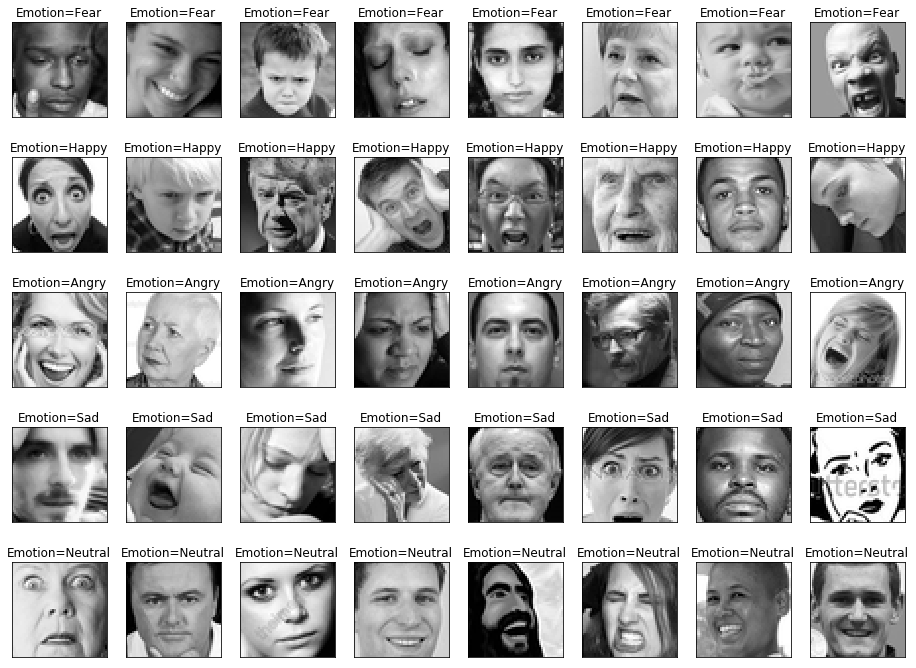

In [5]:
plt.figure(figsize=(16,12))
grid_X = 5
grid_Y = 8
idx = np.random.choice(train_pixels.shape[0],grid_X*grid_Y, replace=False)
sample_images = train_pixels[idx]
sample_labels = train_labels[idx]
for i in range(grid_X):
    for j in range(grid_Y):
        index = i*grid_Y+j
        plt.subplot(grid_X, grid_Y, index+1)
        plt.imshow(sample_images[index], cmap="gray")
        plt.title("Emotion="+emotion_mapping[sample_labels[i]])
        plt.xticks([])
        plt.yticks([])

We need to scale the pixel values and also need to transform the labels using one-hot encoding

In [6]:
pixels=np.expand_dims(train_pixels,axis=3)
val_pixels = np.expand_dims(pub_test_pixels,axis=3)
pixels = pixels/255.0
val_pixels = val_pixels/255.0
labels = tf.keras.utils.to_categorical(train_labels)
val_labels = tf.keras.utils.to_categorical(pub_test_labels)

### Learning Model

We will define a CNN for classifying the facial expressions

In [7]:
padding="Same"
input_layer = tf.keras.layers.Input(shape=pixels[0].shape)
layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding=padding)(input_layer)
layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding=padding)(layer)
layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding=padding)(layer)
layer = tf.keras.layers.MaxPool2D(pool_size=(2,2))(layer)
layer = tf.keras.layers.PReLU()(layer)
layer = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding=padding)(layer)
layer = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding=padding)(layer)
layer = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding=padding)(layer)
layer = tf.keras.layers.MaxPool2D(pool_size=(2,2))(layer)
layer = tf.keras.layers.PReLU()(layer)
layer = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding=padding)(layer)
layer = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding=padding)(layer)
layer = tf.keras.layers.MaxPool2D(pool_size=(2,2))(layer)
layer = tf.keras.layers.PReLU()(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding=padding)(layer)
layer = tf.keras.layers.MaxPool2D(pool_size=(2,2))(layer)
layer = tf.keras.layers.PReLU()(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding=padding)(layer)
layer = tf.keras.layers.MaxPool2D(pool_size=(2,2))(layer)
layer = tf.keras.layers.PReLU()(layer)
layer = tf.keras.layers.Dropout(0.1)(layer)
layer = tf.keras.layers.Flatten()(layer)
layer = tf.keras.layers.Dense(64)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.PReLU()(layer)
layer = tf.keras.layers.Dense(32)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.PReLU()(layer)
layer = tf.keras.layers.Dense(7)(layer)
output_layer = tf.keras.layers.Softmax()(layer)
model = tf.keras.models.Model(input_layer, output_layer) 
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9, decay=1e-4), 
              loss="categorical_crossentropy",metrics=["accuracy"])

In [8]:
model.fit(pixels, labels, epochs=50, verbose=1, batch_size=32,validation_data=(val_pixels, val_labels))

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 15s 524us/step - loss: 1.8340 - acc: 0.2461 - val_loss: 1.8131 - val_acc: 0.2494
Epoch 2/50
28709/28709 [==============================] - 12s 425us/step - loss: 1.8106 - acc: 0.2511 - val_loss: 1.8025 - val_acc: 0.2494
Epoch 3/50
28709/28709 [==============================] - 12s 425us/step - loss: 1.7971 - acc: 0.2536 - val_loss: 1.7869 - val_acc: 0.2491
Epoch 4/50
28709/28709 [==============================] - 12s 425us/step - loss: 1.7889 - acc: 0.2539 - val_loss: 1.7774 - val_acc: 0.2558
Epoch 5/50
28709/28709 [==============================] - 12s 426us/step - loss: 1.7798 - acc: 0.2595 - val_loss: 1.7643 - val_acc: 0.2616
Epoch 6/50
28709/28709 [==============================] - 12s 426us/step - loss: 1.7519 - acc: 0.2796 - val_loss: 1.6830 - val_acc: 0.3221
Epoch 7/50
28709/28709 [==============================] - 12s 425us/step - loss: 1.6995 - acc: 0.3144 - val_loss: 1.6

In [9]:
model.save("models/model.h5")

**Classifications on the Private Test Data**

In [25]:
test_pixels = np.expand_dims(pri_test_pixels,axis=3)
test_pixels = test_pixels/255.0
test_labels = pri_test_labels
predicted_labels = np.argmax(model.predict(test_pixels), axis=1)
accuracy = np.sum(predicted_labels==test_labels)/test_labels.shape[0]
print("Classification Accuracy on the private test data=%.4f"%accuracy)

Classification Accuracy on the private test data=0.6055


Let's see the classifcation along with labels where the X axis represents actual label and the y-axis denotes the predicted label

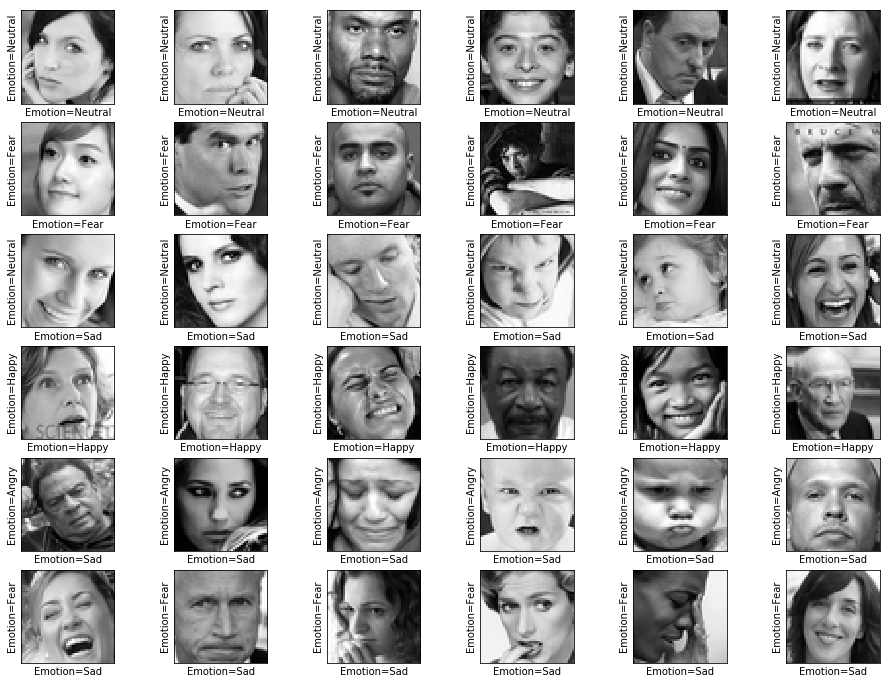

In [37]:
plt.figure(figsize=(16,12))
grid_X = 6
grid_Y = 6
idx = np.random.choice(test_pixels.shape[0],grid_X*grid_Y, replace=False)
test_pixels = test_pixels.reshape(test_pixels.shape[0],test_pixels.shape[1],test_pixels.shape[2])
sample_images = test_pixels[idx]
sample_labels = test_labels[idx]
sample_predcited_labels = predicted_labels[idx]
for i in range(grid_X):
    for j in range(grid_Y):
        index = i*grid_Y+j
        plt.subplot(grid_X, grid_Y, index+1)
        plt.imshow(sample_images[index], cmap="gray")
        plt.xlabel("Emotion="+emotion_mapping[sample_labels[i]])
        plt.ylabel("Emotion="+emotion_mapping[sample_predcited_labels[i]])
        plt.xticks([])
        plt.yticks([])
plt.ti